# Visualise "ground truth" dataset

In [9]:
import os

OUTPUT_PATH = "../plots/png"

# make output folder if needed
os.makedirs(OUTPUT_PATH, exist_ok=True)

### Checking all keys in dataset and their format

In [ ]:
import h5py

with h5py.File("../data/dataset.h5", 'r') as f:
    print("\nKeys found in the HDF5 file:")
    for key in f.keys():
        data = f[key]
        print(f"- {key} : shape={data.shape}, dtype={data.dtype}")


Keys found in the HDF5 file:
- ID_Parcelles : shape=(14836, 24, 24), dtype=float32
- coords : shape=(14836, 2), dtype=float64
- data : shape=(14836, 12, 4, 24, 24), dtype=float32
- dates : shape=(14836,), dtype=object
- labels : shape=(14836, 24, 24), dtype=float32
- zones : shape=(14836,), dtype=object


### Load useful keys for visualisation computation

In [17]:
with h5py.File("../data/dataset.h5", 'r') as f:
    data = f['data'][:]
    labels = f['labels'][:]
    coords = f['coords'][:]
    dates = f['dates'][:]

labels

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [25.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., 14., 14., 14.],
        [ 0.,  0.,  0., ..., 14., 14., 14.],
        [ 0.,  0.,  0., ..., 14., 14., 14.],
        ...,
        [ 0.,  0.,  0., ..., 14., 14., 14.],
        [ 0.,  0.,  0., ..., 14., 14., 14.],
        [ 0.,  0.,  0., ..., 14., 14., 14.]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.

## Visualisation part

### Label distribution

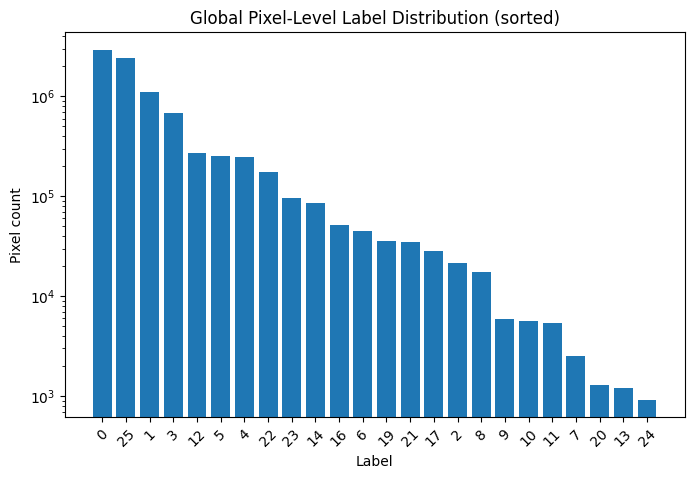

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# flatten all pixel labels
flat = labels.ravel()
uniq, counts = np.unique(flat, return_counts=True)

# sort by counts descending
sort_idx = np.argsort(counts)[::-1]
uniq_sorted  = uniq[sort_idx]
counts_sorted = counts[sort_idx]

# convert labels to strings for ticks
label_strs = uniq_sorted.astype(int).astype(str)

plt.figure(figsize=(8, 5))
plt.bar(label_strs, counts_sorted)
plt.xlabel('Label')
plt.ylabel('Pixel count')
plt.yscale('log') # Help to see low represented labels
plt.title('Global Pixel-Level Label Distribution (sorted)')
plt.xticks(rotation=45)
plt.savefig(OUTPUT_PATH+"/label_distribution.png")
plt.show()
plt.close()


### Patchs example with RGBI bands and True Labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0955752].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1384616].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0617608].


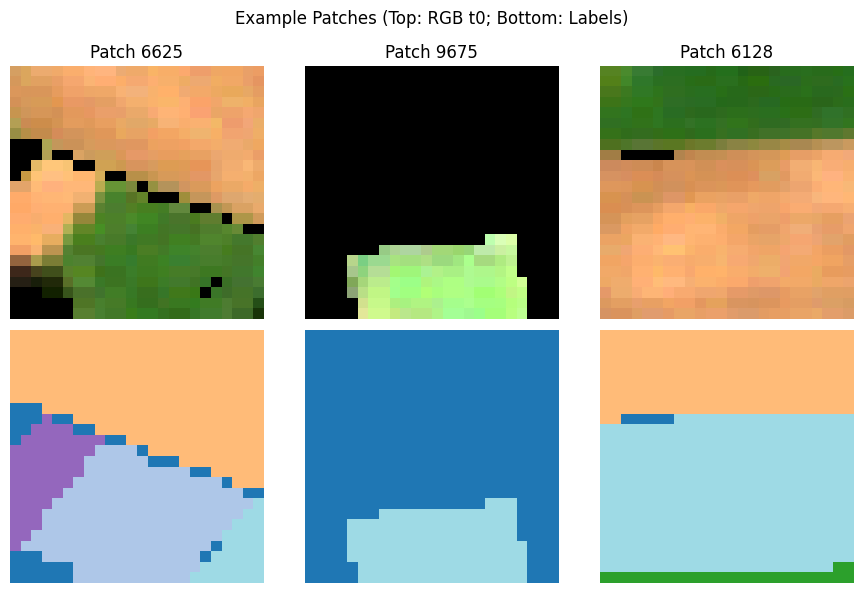

In [ ]:
n_examples=3

N, T, B, H, W = data.shape

picks = np.random.choice(N, size=n_examples, replace=False)
fig, axes = plt.subplots(2, n_examples, figsize=(n_examples*3, 6))
for i, idx in enumerate(picks):
    # RGB at first time
    patch = data[idx, 0]  # (B, H, W)
    rgb = np.stack([patch[2], patch[1], patch[0]], axis=-1)
    axes[0,i].imshow(rgb / np.percentile(rgb,98))
    axes[0,i].axis('off')
    axes[0,i].set_title(f'Patch {idx}')
    # label map
    axes[1,i].imshow(labels[idx], cmap='tab20')
    axes[1,i].axis('off')
fig.suptitle('Example Patches (Top: RGB t0; Bottom: Labels)')
plt.tight_layout()
plt.savefig(OUTPUT_PATH+"/patch_example.png")
plt.show()
plt.close()


### Band value distribution

It's helpfull to control :
- Pixel distribution for each band
- If there is no saturated band
- If we need to normalised values or if it's well distributed
- Detect some artefact or missing value

*X-axis correspond to every pixels (flatten), Y-axis correspond to the value of corresponding pixel for this particular band.*

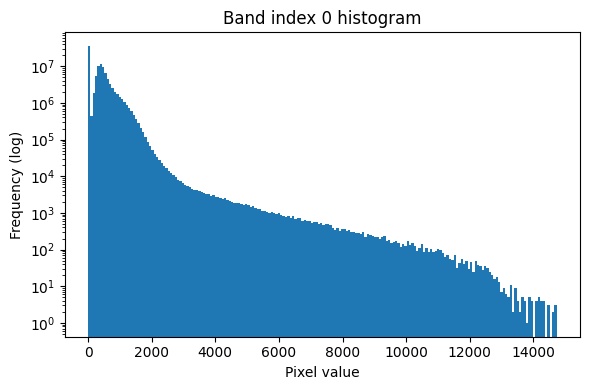

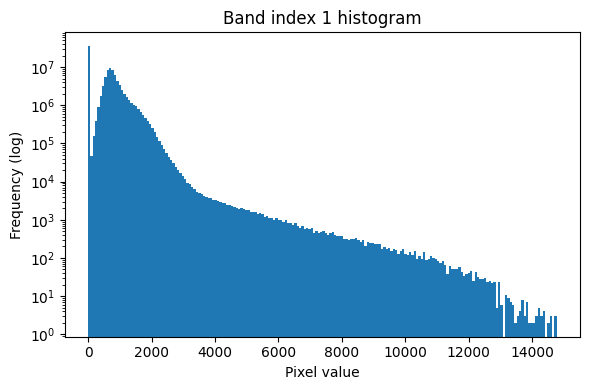

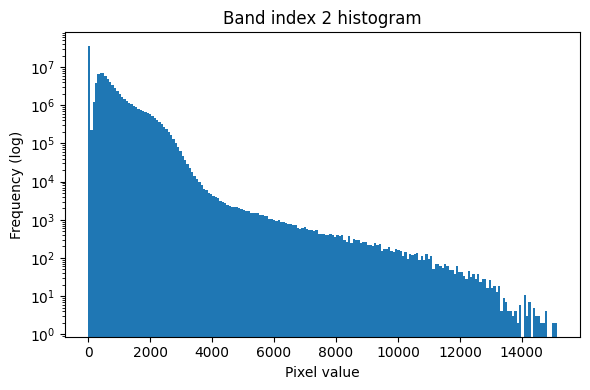

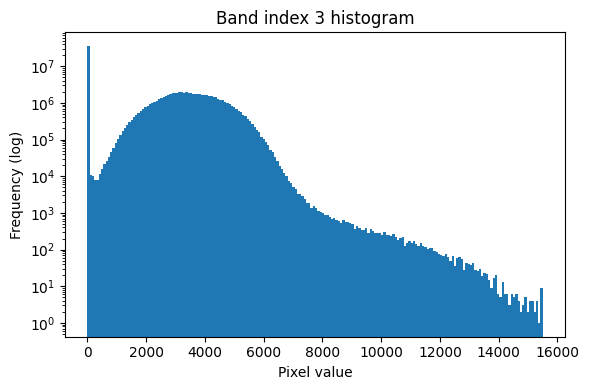

In [25]:
# flatten per band over all samples and times
_, T, B, H, W = data.shape
for b in range(B):
    vals = data[:, :, b].ravel()
    plt.figure(figsize=(6,4))
    plt.hist(vals, bins=200, log=True)
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency (log)')
    plt.title(f'Band index {b} histogram')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, f'band_{b}_hist.png'))
    plt.show()
    plt.close()


### Compute NDVI for few random patches

**NDVI** stands for **Normalized Difference Vegetation Index**. 
It's a commonly used indicator in remote sensing to measure vegetation health.

In [ ]:
# NDVI = (B8 - B4)/(B8 + B4) = (band 3 - band 2)/(band 3 + band 2) zero-based
N, T, B, H, W = data.shape
n_profiles = 5

picks = np.random.choice(N, size=n_profiles, replace=False)
time_axis = np.arange(T)  # [0, 1, ..., 11]

plt.figure(figsize=(8, 5))
for idx in picks:
    patch = data[idx]  # shape (T, B, H, W)
    B4 = patch[:, 2].mean(axis=(1, 2))  # Red
    B8 = patch[:, 3].mean(axis=(1, 2))  # NIR
    ndvi = (B8 - B4) / (B8 + B4 + 1e-6)
    plt.plot(time_axis, ndvi, marker='o', label=f'Patch {idx}')

plt.xlabel('Time step')
plt.ylabel('Mean NDVI')
plt.title('Mean NDVI Over Time (Random Patches)')
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_PATH+"/ndvi.png")
plt.show()
plt.close()